In [1]:
import sys
import numpy as np
import xarray as xr
import dask.array as da
import numpy.ma as ma
from netCDF4 import Dataset

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm

matplotlib.rcParams['figure.figsize']= (20, 8)
matplotlib.rcParams['xtick.labelsize']= 22
matplotlib.rcParams['ytick.labelsize']= 22
matplotlib.rcParams['axes.labelsize']= 22
matplotlib.rcParams.update({'font.size': 22})

import cartopy.crs as ccrs
import matplotlib.ticker as mticker

import cartopy
cartopy.config['pre_existing_data_dir']  = '/home/ad/alberta/git/cartopy_data' 

from decimal import Decimal

%matplotlib inline

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask.dataframe as dd
import dask


In [3]:
cluster = PBSCluster(
    cores=1,
    memory="120GB",
    project='pangeo',
    processes=1,
    walltime='00:30:00',
    local_directory='$TMPDIR')
cluster

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
cluster.scale(20)

In [5]:
client = Client(cluster) # scheduler_file="/home/ad/briolf/scheduler.json")
client

Client Scheduler: tcp://10.120.40.91:41842 Dashboard: http://10.120.40.91:43891/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
!qstat -u albert7a

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 10:
        break
    time.sleep(1)
print(nb_workers)

16


In [7]:
ds_amp=xr.open_dataset('/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60-BLBT02_tidal_amp_y2009m07-y2010m06.nc',chunks={'X':1000,'Y':1000})
ds_phase=xr.open_dataset('/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60-BLBT02_tidal_phase_y2009m07-y2010m06.nc',chunks={'X':1000,'Y':1000})    

In [8]:
ds_grid=xr.open_dataset('/work/ALT/odatis/eNATL60/mesh_mask_eNATL60_3.6_lev1.nc4',chunks={'x':1000,'y':1000})

In [9]:
navlat=ds_grid.nav_lat
navlon=ds_grid.nav_lon
tmask=ds_grid.tmask[0]

In [10]:
indfreq={'M2':0,'S2':1,'N2':2,'O1':3,'K1':4}

In [11]:
def plot_amp_phase_one_freq(freq,vmin,vmax):
    amp=ds_amp['tidal-amp'][indfreq[freq]]
    amp_mask=ma.masked_where(tmask==0.,amp)
    ph=(180/np.pi)*ds_phase['tidal-phase'][indfreq[freq]]
    ph360=da.where(ph<0,ph+360,ph)
    ph360_mask=ma.masked_where(tmask==0.,ph360)    
    cmap=plt.get_cmap('rainbow')
    matplotlib.rcParams['contour.negative_linestyle']= 'solid'
    matplotlib.rcParams['lines.linewidth']= 2

    fig=plt.figure(figsize=(21,18))
    pj= ccrs.PlateCarree()
    ax=plt.subplot(1,1,1,projection=pj)

    ax.coastlines(resolution="10m")
    ax.set_extent([-100,50,0,60])

    gl = ax.gridlines(crs=pj, draw_labels=True, linewidth=1, color='black', alpha=0.2, linestyle='--')
    label_style= {'size' : 20, 'color' : 'black'}
    gl.xlabel_style = label_style
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator(np.arange(-110,100,20,dtype=float))
    gl.ylabels_right = False
    gl.xlabel_style = label_style
    gl.ylocator = mticker.FixedLocator(np.arange(-20,90,10,dtype=float))
    cs = plt.pcolormesh(navlon,navlat,amp_mask,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax)
    plt.contour(navlon,navlat,ph360_mask,[30,60,90,120,150,180,210,240,270,300,330],cmap=plt.get_cmap('tab20b'),linestyle='solid',linewidths=1,transform=ccrs.PlateCarree())
    plt.title(str(freq) +' eNATL60 pytide')
    cbar = plt.colorbar(cs,orientation='vertical',shrink=0.5,label='m')
    plt.savefig('maps_amp_phi_'+str(freq)+'_eNATL60_pytide.png')
    

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


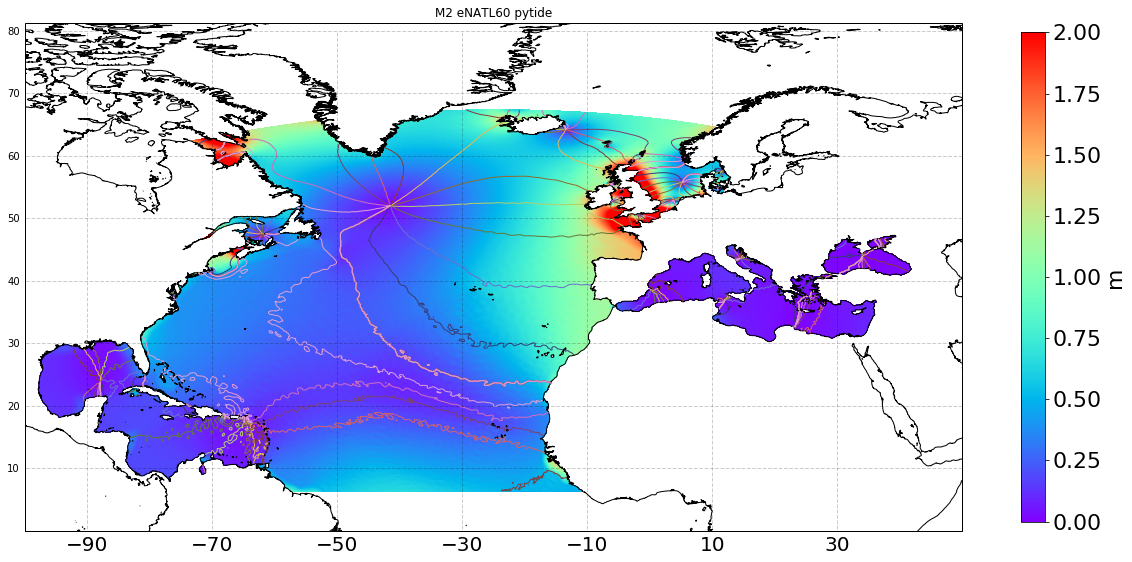

In [12]:
plot_amp_phase_one_freq('M2',0,2)

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


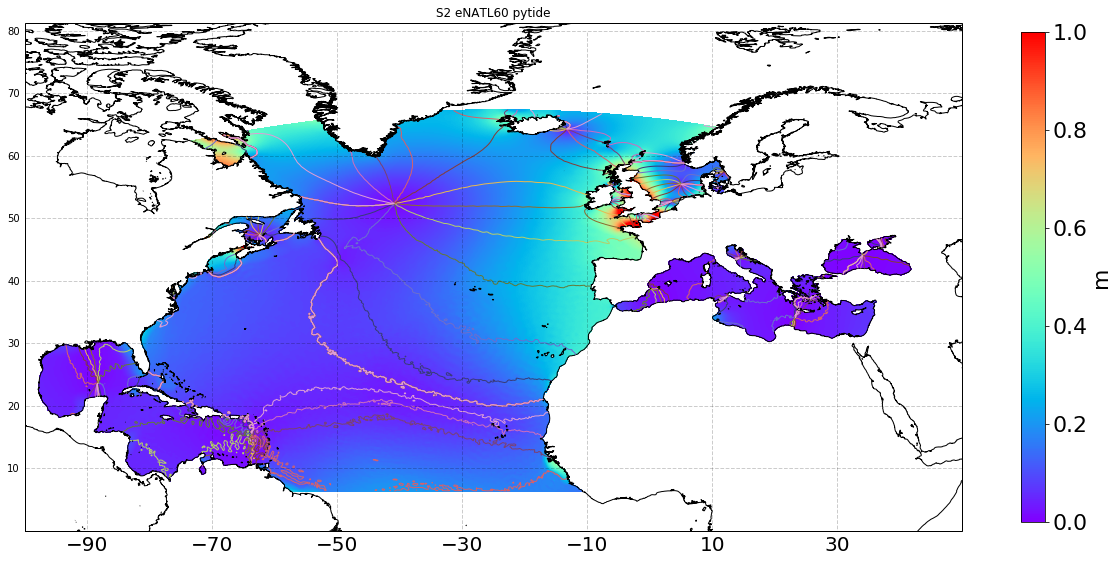

In [13]:
plot_amp_phase_one_freq('S2',0,1)

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


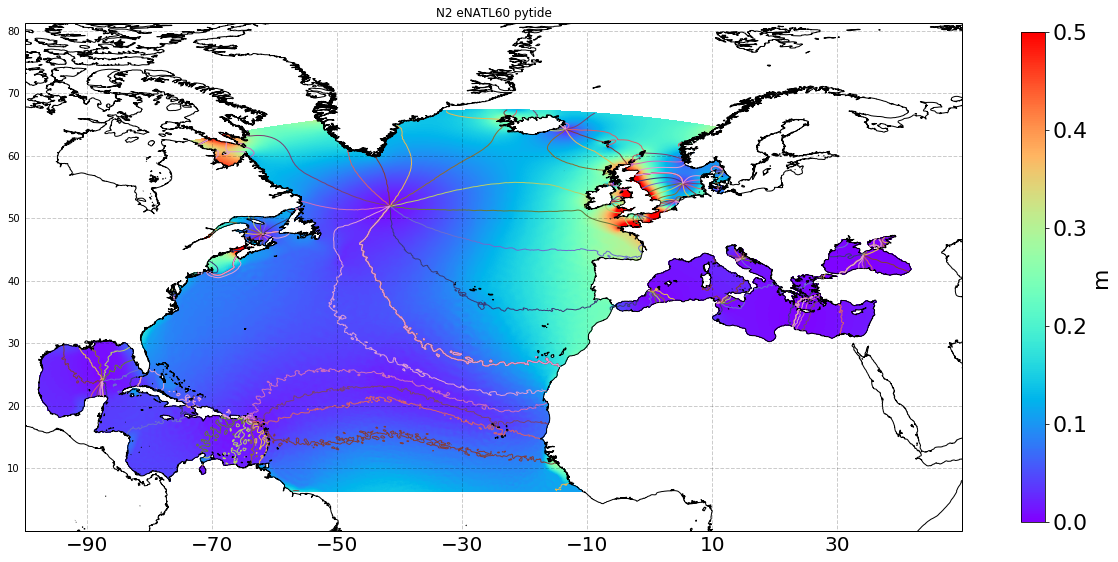

In [14]:
plot_amp_phase_one_freq('N2',0,0.5)

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


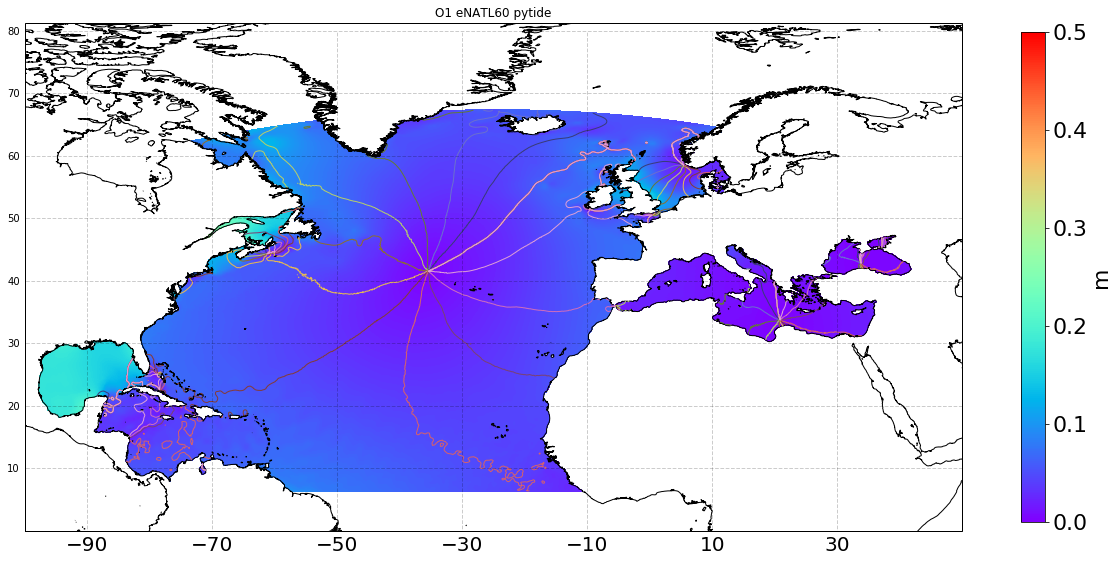

In [15]:
plot_amp_phase_one_freq('O1',0,0.5)

/softs/rh7/conda/4.5.4/envs/pangeo_full_201909/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


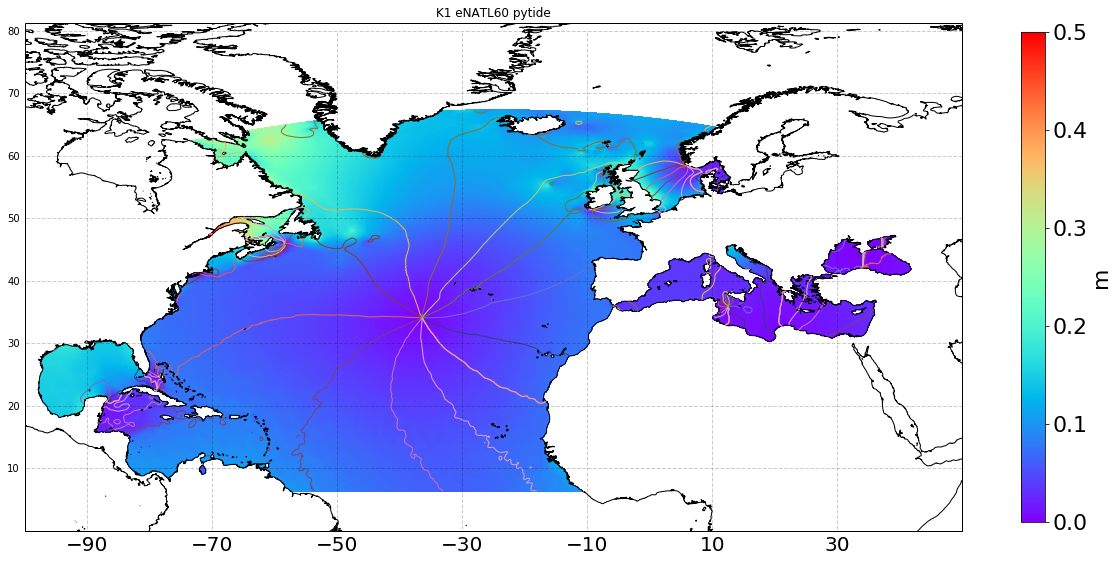

In [16]:
plot_amp_phase_one_freq('K1',0,0.5)